In [1]:
import pandas as pd
import numpy as np

from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

from feature_engine import discretisation as dsc

import networkx as nx
import pylab as plt
import time

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data = pd.read_csv("C:\\Users\\admin\\Desktop\\bank.csv", sep = ';')

In [3]:
data.drop(columns = 'default')

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [4]:
data.shape

(4521, 17)

In [5]:
target = 'y'

In [6]:
col_list = []
for col in data.columns:
    print(col, ": ", len(data[col].unique()))
    if(len(data[col].unique()) > 33):
        col_list.append(col)

age :  67
job :  12
marital :  3
education :  4
default :  2
balance :  2353
housing :  2
loan :  2
contact :  3
day :  31
month :  12
duration :  875
campaign :  32
pdays :  292
previous :  24
poutcome :  4
y :  2


In [7]:
data['previous'] = data['previous'].astype(int)

In [8]:
col_list.append('previous')

In [9]:
num_bins = 3
disc = dsc.EqualFrequencyDiscretiser(q=num_bins, variables=col_list)
data_binned = disc.fit(data[col_list])
equalfrequency_discretizer_dict = disc.binner_dict_
bin_df_equalfrequency = pd.DataFrame.from_dict(
    equalfrequency_discretizer_dict, 
    orient = 'index'
)  

In [10]:
bin_df_equalfrequency

,0,1,2,3
age,-inf,35.0,45.000000,inf
balance,-inf,174.0,979.333333,inf
duration,-inf,128.0,261.333333,inf
pdays,-inf,inf,NaN,NaN
previous,-inf,inf,NaN,NaN


In [11]:
min(data['age'].unique()), max(data['age'].unique())

(19, 87)

In [12]:
bin_age = ['19 to 35', '35 to 45', '45 to 87']

In [13]:
min(data['balance'].unique()), max(data['balance'].unique())

(-3313, 71188)

In [14]:
bin_balance = ['-3313 to 174', '174 to 979', '979 to 71188']

In [15]:
min(data['duration'].unique()), max(data['duration'].unique())

(4, 3025)

In [16]:
bin_duration = ['4 to 128', '128 to 261', '261 to 3025']

In [17]:
min(data['pdays'].unique()), max(data['pdays'].unique())

(-1, 871)

In [18]:
data.drop(columns = 'pdays')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,3,other,no


In [19]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [20]:
data['previous'] = data['previous'].astype(int)

In [21]:
data['age'] = pd.qcut(data['age'], q=[0, 0.4, 0.8, 1], labels= bin_age)
data['balance'] = pd.qcut(data['balance'], q=[0, 0.4, 0.8, 1], labels= bin_balance)
data['duration'] = pd.qcut(data['duration'], q=[0, 0.4, 0.8, 1], labels= bin_duration)

In [22]:
data['previous'] = pd.qcut(data['previous'], q=[0, 0.82, 0.9, 1], labels= ['0 to 7', '7 to 14', '14 to 25'])

In [23]:
data['previous'].value_counts()

0 to 7      3991
14 to 25     337
7 to 14      193
Name: previous, dtype: int64

In [24]:
data_train = data[:4000]
data_test = data[4000:]
data_test = data_test.reset_index(drop=True)
data_train = data_train.drop(columns = ['default','pdays','campaign'])
data_test = data_test.drop(columns = ['default','pdays','campaign'])

In [25]:
hc = HillClimbSearch(data_train)
best_model = hc.estimate(scoring_method=BicScore(data_train))
edges = list(best_model.edges())
model = BayesianModel(edges)



  0%|          | 0/1000000 [00:00<?, ?it/s]

<Figure size 1500x1000 with 0 Axes>

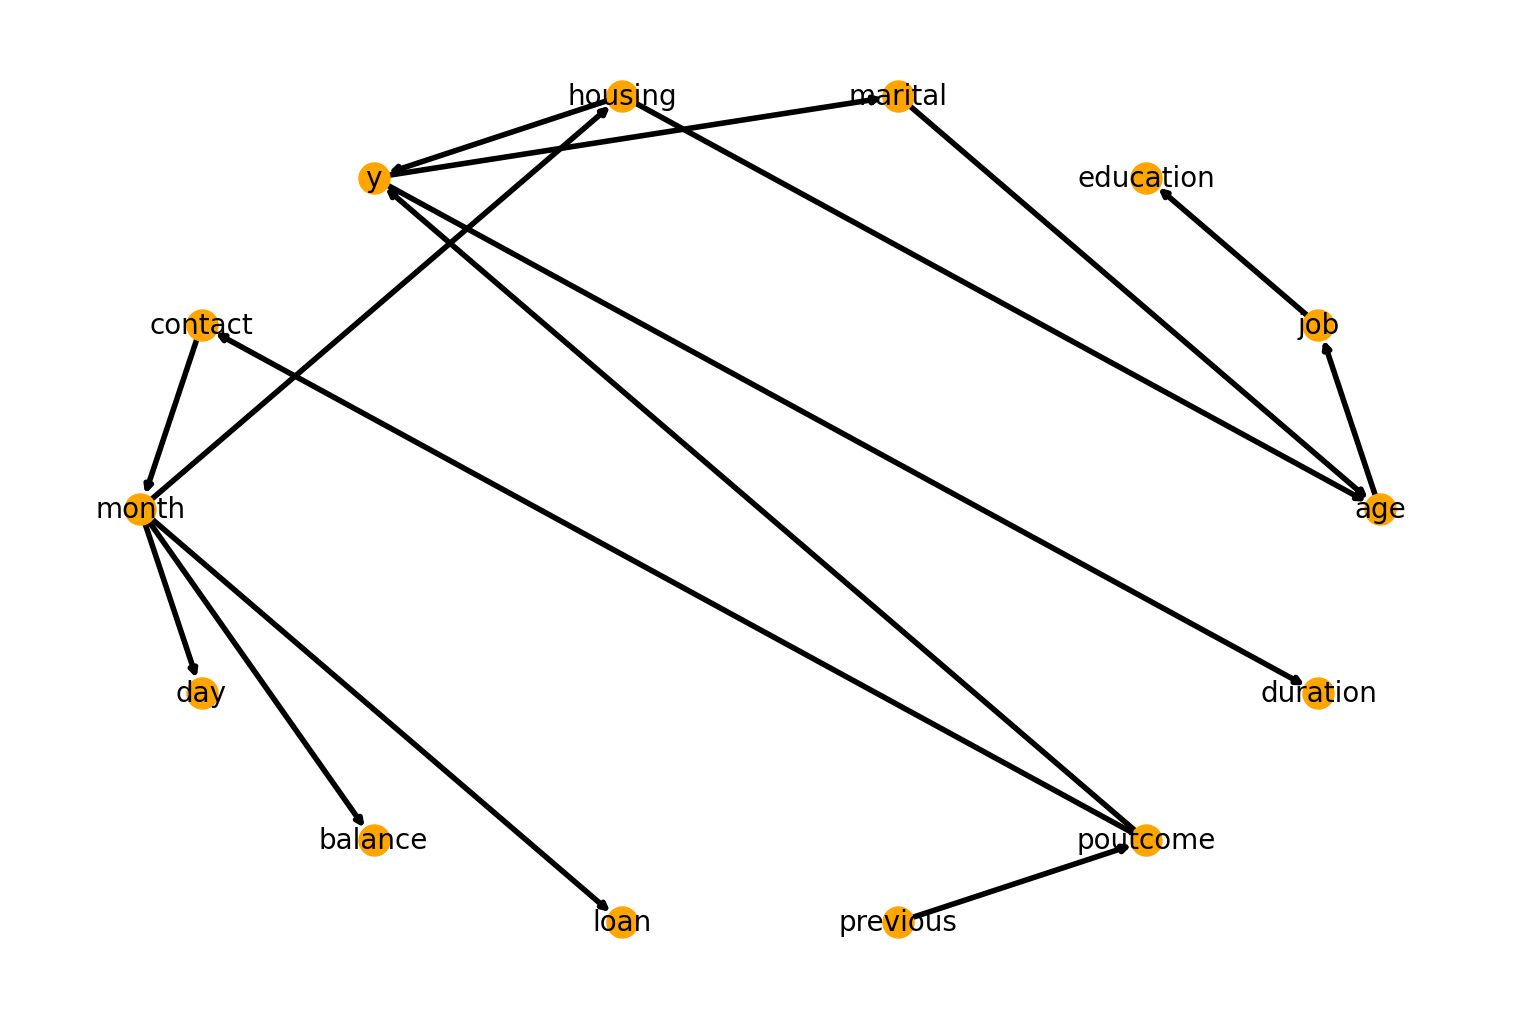

In [26]:
%matplotlib inline
plt.figure(figsize=(15,10))

layout = nx.circular_layout(model)

# Adjust node_size and other parameters
nx.draw(
    model, pos=layout, 
    with_labels=True, node_size=500, node_color="orange", 
    width=4, font_size=20
)
plt.show()

In [27]:
model.fit(data_train, estimator=MaximumLikelihoodEstimator)

infer = VariableElimination(model)

In [28]:
model.get_children(target)

['duration', 'marital']

In [29]:
model.get_parents(target)

['housing', 'poutcome']

In [30]:
print(infer.query(variables=[target, 'marital'], joint= True))

+--------+-------------------+------------------+
| y      | marital           |   phi(y,marital) |
+========+===================+==================+
| y(no)  | marital(divorced) |           0.0972 |
+--------+-------------------+------------------+
| y(no)  | marital(married)  |           0.5614 |
+--------+-------------------+------------------+
| y(no)  | marital(single)   |           0.2267 |
+--------+-------------------+------------------+
| y(yes) | marital(divorced) |           0.0165 |
+--------+-------------------+------------------+
| y(yes) | marital(married)  |           0.0613 |
+--------+-------------------+------------------+
| y(yes) | marital(single)   |           0.0368 |
+--------+-------------------+------------------+


In [31]:
print(infer.query(variables=[target], evidence={'marital': 'married'}))
print(infer.query(variables=[target], evidence={'marital': 'divorced'}))
print(infer.query(variables=[target], evidence={'marital': 'single'}))

+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.9015 |
+--------+----------+
| y(yes) |   0.0985 |
+--------+----------+
+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.8547 |
+--------+----------+
| y(yes) |   0.1453 |
+--------+----------+
+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.8603 |
+--------+----------+
| y(yes) |   0.1397 |
+--------+----------+


In [32]:
data_test_subset = data_test.drop(columns = ['y'])

In [33]:
data_test_subset = data_test_subset.reset_index(drop=True)

In [34]:
data_test_subset

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,previous,poutcome
0,45 to 87,admin.,divorced,secondary,-3313 to 174,yes,no,cellular,7,may,4 to 128,0 to 7,failure
1,19 to 35,technician,married,secondary,-3313 to 174,no,no,cellular,31,aug,4 to 128,0 to 7,unknown
2,45 to 87,technician,divorced,secondary,-3313 to 174,no,no,cellular,5,aug,4 to 128,0 to 7,unknown
3,19 to 35,student,single,secondary,-3313 to 174,no,no,unknown,4,jun,4 to 128,0 to 7,unknown
4,19 to 35,technician,single,secondary,-3313 to 174,no,no,cellular,19,aug,128 to 261,0 to 7,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,19 to 35,services,married,secondary,-3313 to 174,yes,no,cellular,30,jul,128 to 261,0 to 7,unknown
517,45 to 87,self-employed,married,tertiary,-3313 to 174,yes,yes,unknown,9,may,128 to 261,0 to 7,unknown
518,45 to 87,technician,married,secondary,174 to 979,no,no,cellular,19,aug,128 to 261,0 to 7,unknown
519,19 to 35,blue-collar,married,secondary,174 to 979,no,no,cellular,6,feb,4 to 128,14 to 25,other


In [35]:
predictions = model.predict(data_test_subset)
actual_labels = data_test['y']
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(actual_labels, predictions)
classification_rep = classification_report(actual_labels, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

  0%|          | 0/519 [00:00<?, ?it/s]

Accuracy: 0.8925143953934741
Classification Report:
               precision    recall  f1-score   support

          no       0.90      0.99      0.94       458
         yes       0.73      0.17      0.28        63

    accuracy                           0.89       521
   macro avg       0.82      0.58      0.61       521
weighted avg       0.88      0.89      0.86       521

